<a href="https://colab.research.google.com/github/KonstantinBurkin/World_vaccination_data_analysis/blob/Edits-to-use-this-project-for-CV/World_vaccination_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**"World vaccination data analysis" project**#

> **MSU course: "Basics of programming and data analysis in Python"**






---

## Download data

- Import necessary libraries 
- Import data from Github
- Create dataset in Python

Data from:
https://www.kaggle.com/gpreda/covid-world-vaccination-progress or https://github.com/owid/covid-19-data

In [8]:
# Import libraries
from google.colab import output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
from datetime import timedelta, date, datetime

In [9]:
# Download data from Github
!wget -O "vaccinations.csv" "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"
output.clear()

In [10]:
# Create dataset
data_table = pd.read_csv("vaccinations.csv")

## Analysis of raw dataset

- Display raw dataset 
- Choose the necessary parameters from the table
- Modify dataset
- Analyze data types in the dataset
- Description of parameters in the dataset
- Overall statistical characteristics of the dataset

In [11]:
# display the first column with the names of the columns
data_table.head(1)

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [12]:
# Delete unnecessary columns
data_table.drop(labels=['daily_vaccinations_raw', 'daily_vaccinations', 'iso_code', 'daily_people_vaccinated', 'daily_people_vaccinated_per_hundred', 'daily_vaccinations_per_million', 'total_boosters', 'total_boosters_per_hundred'], axis='columns', inplace=True)

In [13]:
# Modify the names of the columns
data_table.rename(columns={'location': 'country'}, inplace=True)

def column_name_preprocess(col_name):
    for char in ['total_', 'people_']:
        col_name = col_name.replace(char, '')
        col_name = col_name.replace('_per_hundred', '_ratio')
    return col_name

column_names = data_table.columns
data_table.columns = [column_name_preprocess(col_name).title() for col_name in column_names]

In [14]:
# display the first column with the modified names of the columns
data_table.head(1)

,Country,Date,Vaccinations,Vaccinated,Fully_Vaccinated,Vaccinations_Ratio,Vaccinated_Ratio,Fully_Vaccinated_Ratio
0,Afghanistan,2021-02-22,0.0,0.0,NaN,0.0,0.0,NaN


In [15]:
# Analyze data types in the dataset
data_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81314 entries, 0 to 81313
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 81314 non-null  object 
 1   Date                    81314 non-null  object 
 2   Vaccinations            44416 non-null  float64
 3   Vaccinated              42368 non-null  float64
 4   Fully_Vaccinated        39680 non-null  float64
 5   Vaccinations_Ratio      44416 non-null  float64
 6   Vaccinated_Ratio        42368 non-null  float64
 7   Fully_Vaccinated_Ratio  39680 non-null  float64
dtypes: float64(6), object(2)
memory usage: 5.0+ MB


###Detailed description of parameters
* *Country* - this is the country for which the vaccination information is 
provided;	**Categorical**
* *Date* - date for the data entry; **Categorical**
* *Vaccinations* - this is the absolute number of total immunizations in the country; **Numerical**
* *Vaccinated* - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people; **Numerical**
* *Fully_Vaccinated* - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); **Numerical**
* *Vaccinations, %* -  ratio between vaccination number and total population up to the date in the country; **Numerical**
* *Vaccinated, %* - ratio between population immunized and total population up to the date in the country; **Numerical**
* *Fully_Vaccinated, %* - ratio between population fully immunized and total population up to the date in the country; **Numerical**

In [16]:
# Statistical characteristics of the dataset
data_table.describe(percentiles=[.25, .75, .90])

,Vaccinations,Vaccinated,Fully_Vaccinated,Vaccinations_Ratio,Vaccinated_Ratio,Fully_Vaccinated_Ratio
count,4.441600e+04,4.236800e+04,3.968000e+04,44416.000000,42368.000000,39680.000000
mean,1.551962e+08,8.044456e+07,6.191693e+07,70.416227,37.375697,31.395963
std,7.146514e+08,3.731844e+08,3.019207e+08,62.189781,28.615809,27.333375
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000
25%,5.955178e+05,3.956628e+05,2.646492e+05,11.670000,8.430000,4.600000
50%,4.419004e+06,2.713338e+06,2.042351e+06,56.385000,35.570000,25.420000
75%,2.711137e+07,1.598297e+07,1.237331e+07,120.400000,64.010000,56.570000
90%,1.478994e+08,8.021985e+07,5.819107e+07,157.905000,76.030000,70.301000
max,1.034232e+10,4.860742e+09,4.239823e+09,331.950000,123.640000,120.930000


Vaccinations, %  | 	Vaccinated, %  | 	Fully_Vaccinated, %: 
> more than 100% - b/c several vaccination doses




## Cleaning of dataset

- Missing values analysis
- Filling missing values

In [17]:
# Missing values analysis
data_table.isna().any()

Country                   False
Date                      False
Vaccinations               True
Vaccinated                 True
Fully_Vaccinated           True
Vaccinations_Ratio         True
Vaccinated_Ratio           True
Fully_Vaccinated_Ratio     True
dtype: bool

In [19]:
# Filling missing values with data using linear approximation

countries = list(data_table.Country.unique())     # List of all countries and continents

for country in countries:
    data_table.loc[data_table['Country'] == country] = \
    data_table.loc[data_table['Country'] == country].interpolate(method='linear')

In [ ]:
data_table.head(1)

## Descriptive analysis and visualisation in graphs

- Provide list of all countries and continents
- Analyze the vaccination rates of any country or continent

In [32]:
# List of all countries and continents
print(*countries)

Afghanistan Africa Albania Algeria Andorra Angola Anguilla Antigua and Barbuda Argentina Armenia Aruba Asia Australia Austria Azerbaijan Bahamas Bahrain Bangladesh Barbados Belarus Belgium Belize Benin Bermuda Bhutan Bolivia Bonaire Sint Eustatius and Saba Bosnia and Herzegovina Botswana Brazil British Virgin Islands Brunei Bulgaria Burkina Faso Burundi Cambodia Cameroon Canada Cape Verde Cayman Islands Central African Republic Chad Chile China Colombia Comoros Congo Cook Islands Costa Rica Cote d'Ivoire Croatia Cuba Curacao Cyprus Czechia Democratic Republic of Congo Denmark Djibouti Dominica Dominican Republic Ecuador Egypt El Salvador England Equatorial Guinea Estonia Eswatini Ethiopia Europe European Union Faeroe Islands Falkland Islands Fiji Finland France French Polynesia Gabon Gambia Georgia Germany Ghana Gibraltar Greece Greenland Grenada Guatemala Guernsey Guinea Guinea-Bissau Guyana Haiti High income Honduras Hong Kong Hungary Iceland India Indonesia Iran Iraq Ireland Isle of

Enter the country: Sweden


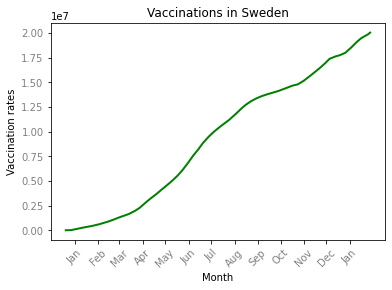

In [31]:
# Analyze the vaccination rates of any country or continent

# List of the months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] 

country = input('Enter the country: ')

x = list(data_table[data_table['Country'] == country].Date)
y = data_table[data_table['Country'] == country].Vaccinations

f1 = plt.figure(1)

plt.title(f'Vaccinations in {country}')
plt.xlabel('Month')
plt.ylabel('Vaccination rates')

# Data ticks - middle of the months - 15th days
tick_values = [index for index,value in enumerate(x) if '-15' in value]

# Creating names of the months for the ticks
tick_names = []
for i in tick_values:
    tick_names.append(months[int(str(x[i])[5:7])-1]) 
tick_names_new = [elem[:3] for elem in tick_names]

plt.xticks(tick_values, tick_names_new, rotation =45, color='grey')
plt.yticks(color='grey')


plt.plot(x, y, linewidth=2, color='green')  
f1.show()

## Predictive analysis

- Prediction of the end of vaccination of population of any continent
- Prediction created using linear approximation for the recent data obtained

Enter the continent (South America, North America, Europe, Asia, Australia, Africa): Europe
The day of the end of vaccinations: 2023-03-06


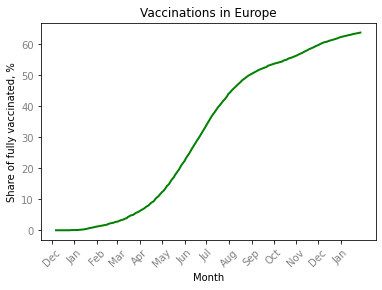

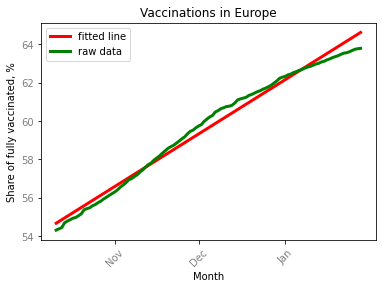

In [25]:
country = input('Enter the continent (South America, North America, Europe, Asia, Australia, Africa): ')

x = list(data_table[data_table['Country'] == country].Date)
y = data_table[data_table['Country'] == country].Fully_Vaccinated_Ratio

f1 = plt.figure(1)

plt.title(f'Vaccinations in {country}')
plt.xlabel('Month')
plt.ylabel('Share of fully vaccinated, %')

# Data ticks - middle of the months - 15th days
tick_values = [index for index,value in enumerate(x) if '-15' in value]
# Creating names of the months for the ticks
tick_names = []
for i in tick_values:
    tick_names.append(months[int(str(x[i])[5:7])-1]) 
tick_names_new = [elem[:3] for elem in tick_names]

plt.xticks(tick_values, tick_names_new, rotation =45, color='grey')
plt.yticks(color='grey')


plt.plot(x, y, linewidth=2, color='green')  
f1.show()

'''________________________________________________________________'''

# Choose the right (recent data) site of the graph and use linear approximation

x = list(data_table[data_table['Country'] == country].Date)
x = x[int(len(x)*3/4):]

y = data_table[data_table['Country'] == country].Fully_Vaccinated_Ratio
y = y[int(len(y)*3/4):]

f2 = plt.figure(2)

plt.title(f'Vaccinations in {country}')
plt.xlabel('Month')
plt.ylabel('Share of fully vaccinated, %')


# Data ticks - middle of the months - 15th days
tick_values = [index for index,value in enumerate(x) if '-15' in value]

# Creating names of the months for the ticks
tick_names = []
for i in tick_values:
    tick_names.append(months[int(str(x[i])[5:7])-1]) 
tick_names_new = [elem[:3] for elem in tick_names]

first_day = x[0]
x = range(len(x))

plt.xticks(tick_values, tick_names_new, rotation =45, color='grey')
plt.yticks(color='grey')

approximation = sps.linregress(x,y)
plt.plot(x, approximation.intercept + approximation.slope*x, 'r', linewidth=3, label='fitted line')

plt.plot(x, y, linewidth=3, color='green', label='raw data')  
plt.legend()
f2.show()

'''____________________________________________________________________________'''

# Calculate the day of the end of vaccinations
# y = k * x + b
k = approximation.slope
b = approximation.intercept

days_left = (100.0 - b)/k             # number of days till the end of vaccination
final_day = datetime.strptime(first_day, '%Y-%m-%d') + timedelta(days=days_left)
final_day = datetime.date(final_day)  # the day of the end of vaccinations

print(f'The day of the end of vaccinations: {final_day}')